In [1]:
import sys
import os
import scipy.ndimage as nd
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as sk
from utils import utils
plt.style.use('ggplot')

In [2]:
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data

import torch
import PIL.ImageOps

#### Load dataset

In [3]:
transformations = [tfs.RandomAffine(0., scale=(0.5, 1.), fillcolor=0),
                   tfs.Resize((64, 64)),
                   tfs.Grayscale(1),
                   tfs.Lambda(lambda x: PIL.ImageOps.invert(x))]

imagenet_data = datasets.ImageFolder('data/png_clasificados/',
                                     transform=tfs.Compose(transformations))

data_loader = data.DataLoader(imagenet_data, batch_size=4, shuffle=True)

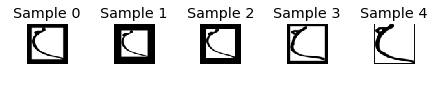

In [4]:
fig = plt.figure()

for i in range(len(imagenet_data)):
    sample = imagenet_data[i + 10]
    #print(sample)
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    plt.imshow(np.asarray(sample[0]), cmap=plt.cm.gray_r)
    ax.set_title('Sample {}'.format(i))
    ax.axis('off')

    if i == 4:
        plt.show()
        break

#### Process type of vessels for classification

In [11]:
df = utils.create_df_from_files(path='data/clases/')
# destination = "data/perfiles_CATA/png_clasificados/"
# path = "data/perfiles_CATA/png"
# utils.create_folder_pytorch_format(df, destination, path)

#### Build and train classifier

In [5]:
imagenet_data = datasets.ImageFolder('data/png_clasificados/',
                                     transform=tfs.Compose([tfs.RandomHorizontalFlip(p=0.7),
                                                           tfs.RandomAffine(0, scale=(0.7, 1.), fillcolor=0),
                                                           tfs.Resize((64, 64)),
                                                           tfs.Grayscale(1),
                                                           tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
                                                           tfs.ToTensor(),
                                                           tfs.Normalize((0.5,), (0.5,))]))

#data_loader = data.DataLoader(imagenet_data, batch_size=64, shuffle=True)

In [6]:
len(imagenet_data.samples), round(1133*0.2), round(1133*0.7), round(1133*0.1)

(1133, 227, 793, 113)

#### Random split

In [7]:
splits = utils.random_split(imagenet_data, [227, 113, 793])

train_loader = data.DataLoader(splits[2], batch_size=32, shuffle=True)
val_loader = data.DataLoader(splits[1], batch_size=32, shuffle=True)
test_loader = data.DataLoader(splits[0], batch_size=32, shuffle=True)


In [8]:
import torch.optim as optim
from torch import nn
from models.classifier import _C
import visdom
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import CategoricalAccuracy, Loss
import torch.nn.functional as F

In [11]:
C =_C(input_h_w=64)
C = C.cuda()
criterion = nn.CrossEntropyLoss().cuda()
C_optimizer = optim.Adam(C.parameters(), lr=0.0002, betas=(0.5, 0.999))

vis = visdom.Visdom()
log_interval = 10
trainer = create_supervised_trainer(C, C_optimizer, F.cross_entropy, device='cuda')
evaluator = create_supervised_evaluator(C, metrics={'accuracy': CategoricalAccuracy(),
                                                     'ce_ll': Loss(F.cross_entropy)},
                                           device='cuda')

train_avg_loss_window = utils.create_plot_window(vis, '#Iterations', 'Loss', 
                                                 'Training Average Loss')
train_avg_accuracy_window = utils.create_plot_window(vis, '#Iterations', 'Accuracy',
                                                     'Training Average Accuracy')
val_avg_loss_window = utils.create_plot_window(vis, '#Epochs', 'Loss',
                                               'Validation Average Loss')
val_avg_accuracy_window = utils.create_plot_window(vis, '#Epochs', 'Accuracy',
                                                   'Validation Average Accuracy')


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_nll = metrics['ce_ll']
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_nll))
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_accuracy]),
             win=train_avg_accuracy_window, update='append')
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_nll]),
             win=train_avg_loss_window, update='append')

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_nll = metrics['ce_ll']
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_nll))
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_accuracy]),
             win=val_avg_accuracy_window, update='append')
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_nll]),
             win=val_avg_loss_window, update='append')

trainer.run(train_loader, max_epochs=100)

Training Results - Epoch: 1  Avg accuracy: 0.29 Avg loss: 2.27
Validation Results - Epoch: 1  Avg accuracy: 0.27 Avg loss: 2.28
Training Results - Epoch: 2  Avg accuracy: 0.66 Avg loss: 2.07
Validation Results - Epoch: 2  Avg accuracy: 0.61 Avg loss: 2.09
Training Results - Epoch: 3  Avg accuracy: 0.71 Avg loss: 1.86
Validation Results - Epoch: 3  Avg accuracy: 0.66 Avg loss: 1.89
Training Results - Epoch: 4  Avg accuracy: 0.73 Avg loss: 1.79
Validation Results - Epoch: 4  Avg accuracy: 0.70 Avg loss: 1.83
Training Results - Epoch: 5  Avg accuracy: 0.73 Avg loss: 1.77
Validation Results - Epoch: 5  Avg accuracy: 0.65 Avg loss: 1.82
Training Results - Epoch: 6  Avg accuracy: 0.76 Avg loss: 1.75
Validation Results - Epoch: 6  Avg accuracy: 0.72 Avg loss: 1.78
Training Results - Epoch: 7  Avg accuracy: 0.78 Avg loss: 1.75
Validation Results - Epoch: 7  Avg accuracy: 0.70 Avg loss: 1.78
Training Results - Epoch: 8  Avg accuracy: 0.77 Avg loss: 1.74
Validation Results - Epoch: 8  Avg accura

Validation Results - Epoch: 64  Avg accuracy: 0.82 Avg loss: 1.69
Training Results - Epoch: 65  Avg accuracy: 0.91 Avg loss: 1.60
Validation Results - Epoch: 65  Avg accuracy: 0.84 Avg loss: 1.68
Training Results - Epoch: 66  Avg accuracy: 0.95 Avg loss: 1.59
Validation Results - Epoch: 66  Avg accuracy: 0.87 Avg loss: 1.68
Training Results - Epoch: 67  Avg accuracy: 0.89 Avg loss: 1.62
Validation Results - Epoch: 67  Avg accuracy: 0.78 Avg loss: 1.70
Training Results - Epoch: 68  Avg accuracy: 0.92 Avg loss: 1.59
Validation Results - Epoch: 68  Avg accuracy: 0.86 Avg loss: 1.66
Training Results - Epoch: 69  Avg accuracy: 0.93 Avg loss: 1.59
Validation Results - Epoch: 69  Avg accuracy: 0.82 Avg loss: 1.70
Training Results - Epoch: 70  Avg accuracy: 0.93 Avg loss: 1.59
Validation Results - Epoch: 70  Avg accuracy: 0.86 Avg loss: 1.67
Training Results - Epoch: 71  Avg accuracy: 0.91 Avg loss: 1.59
Validation Results - Epoch: 71  Avg accuracy: 0.83 Avg loss: 1.67
Training Results - Epoch

In [13]:
val_loader.dataset, train_loader.dataset, test_loader.dataset

(<utils.utils.Subset at 0x7f5c10f2fda0>,
 <utils.utils.Subset at 0x7f5c10f2fa20>)

In [13]:
from torchsummary import summary

summary(C, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,088
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,200
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Linear-6                 [-1, 1024]      33,555,456
       BatchNorm1d-7                 [-1, 1024]           2,048
         LeakyReLU-8                 [-1, 1024]               0
            Linear-9                   [-1, 11]          11,275
          Sigmoid-10                   [-1, 11]               0
Total params: 33,701,323
Trainable params: 33,701,323
Non-trainable params: 0
----------------------------------------------------------------


### Confusion matrix and classification report

In [126]:
import torchnet

confusion_window = utils.create_plot_window(vis, 'True Labels', 'Predicted', 'Confusion Matrix')

confusion_matrix = torchnet.meter.ConfusionMeter(11, normalized=True)
for ii, data_ in enumerate(test_loader):
    input_, label = data_
    val_input = Variable(input_).cuda()
    val_label = Variable(label.type(torch.LongTensor)).cuda()
    score = C(val_input)
    confusion_matrix.add(score.data.squeeze(), label.type(torch.LongTensor))
    
np.set_printoptions(precision=3)
print(confusion_matrix.value())
print(confusion_matrix.conf)
vis.heatmap(confusion_matrix.value(), win=confusion_window)

[[1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.973 0.027 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.032 0.968 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.125 0.    0.5   0.125 0.    0.    0.125 0.    0.125 0.   ]
 [0.    0.    0.    0.    0.846 0.    0.    0.    0.077 0.077 0.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.1   0.9   0.    0.    0.   ]
 [0.    0.    0.    0.    0.111 0.    0.    0.    0.778 0.111 0.   ]
 [0.    0.    0.    0.016 0.047 0.    0.    0.016 0.    0.922 0.   ]
 [0.    0.    0.    0.    0.333 0.    0.    0.    0.    0.    0.667]]
[[ 5  0  0  0  0  0  0  0  0  0  0]
 [ 0 73  2  0  0  0  0  0  0  0  0]
 [ 0  1 30  0  0  0  0  0  0  0  0]
 [ 0  1  0  4  1  0  0  1  0  1  0]
 [ 0  0  0  0 11  0  0  0  1  1  0]
 [ 0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  

'window_365b604fcc212c'

In [83]:
from sklearn import metrics

def iterations_test(C, test_loader):
    y_real = list()
    y_pred = list()

    for ii, data_ in enumerate(test_loader):
        input_, label = data_
        val_input = Variable(input_).cuda()
        val_label = Variable(label.type(torch.LongTensor)).cuda()
        score = C(val_input)
        _, y_pred_batch = torch.max(score, 1)
        y_pred_batch = y_pred_batch.cpu().squeeze().numpy()
        y_real_batch = val_label.cpu().data.squeeze().numpy()
        y_real.append(y_real_batch.tolist())
        y_pred.append(y_pred_batch.tolist())

    y_real = [item for batch in y_real for item in batch]
    y_pred = [item for batch in y_pred for item in batch]
    
    return y_real, y_pred

In [123]:
y_real, y_pred = iterations_test(C, test_loader)
print(metrics.classification_report(np.array(y_pred), np.array(y_real)))

             precision    recall  f1-score   support

          0       0.80      1.00      0.89         4
          1       0.95      0.97      0.96        73
          2       0.97      0.91      0.94        33
          3       0.38      0.75      0.50         4
          4       0.92      0.63      0.75        19
          5       0.50      0.50      0.50         2
          6       1.00      0.88      0.93         8
          7       0.80      0.89      0.84         9
          8       0.67      0.86      0.75         7
          9       0.92      0.89      0.91        66
         10       0.67      1.00      0.80         2

avg / total       0.91      0.89      0.90       227



In [125]:
avg_acc = list()
for i in range(5):
    y_real, y_pred = iterations_test(C, test_loader)
    avg_acc.append(metrics.accuracy_score(np.array(y_pred), np.array(y_real)))
print(np.mean(avg_acc), avg_acc)

0.905726872246696 [0.9162995594713657, 0.8986784140969163, 0.9074889867841409, 0.8942731277533039, 0.9118942731277533]
